In [19]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
# Load dataset
df = pd.read_csv('test-data/2022_dataset.csv')

In [21]:
# Replace missing values with NaN
df.replace("", np.nan, inplace=True)

In [22]:
df.isnull().sum()

Date        0
AT          0
MinT        0
MaxT        0
PRE       261
AWS         0
MaxWD       0
MaxIWD      0
MaxWS       0
MaxIWS      0
RH          1
DT         39
CA          0
Result      0
dtype: int64

In [23]:
df[df['PRE'].isnull()]

,Date,AT,MinT,MaxT,PRE,AWS,MaxWD,MaxIWD,MaxWS,MaxIWS,RH,DT,CA,Result
0,2022-01-01,-4.3,-10.2,2.3,NaN,1.5,2,4,2.8,4.5,46.3,9.0,1.4,0.0125
2,2022-01-03,-1.9,-8.0,2.5,NaN,1.8,12,13,4.1,6.9,58.3,7.8,4.9,0.0086
3,2022-01-04,-2.5,-5.6,1.0,NaN,2.4,12,13,4.2,6.8,51.8,9.0,0.0,0.0170
4,2022-01-05,-2.8,-7.8,1.9,NaN,1.7,3,3,2.9,4.2,47.6,1.9,7.3,0.0062
5,2022-01-06,-2.2,-5.9,3.3,NaN,2.3,14,14,4.6,7.8,47.1,9.1,0.0,0.0130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,2022-12-26,-3.9,-7.9,1.7,NaN,1.4,3,16,2.8,3.7,68.4,7.6,1.4,0.0061
360,2022-12-27,-2.6,-7.3,3.3,NaN,1.8,14,14,3.2,5.4,69.8,8.8,0.1,0.0066
362,2022-12-29,-2.9,-7.8,2.1,NaN,1.7,14,15,3.4,5.1,56.3,9.0,3.3,0.0127
363,2022-12-30,-1.8,-4.4,2.3,NaN,1.9,13,13,4.6,7.5,65.6,7.9,1.4,0.0150


In [24]:
df[df['DT'].isnull()]

,Date,AT,MinT,MaxT,PRE,AWS,MaxWD,MaxIWD,MaxWS,MaxIWS,RH,DT,CA,Result
18,2022-01-19,-5.3,-7.7,-2.7,1.7,2.1,15,15,4.7,8.3,72.3,NaN,5.1,0.0104
24,2022-01-25,2.8,1.9,4.5,0.7,2.3,13,12,4.9,7.7,80.0,NaN,9.4,0.0176
71,2022-03-13,11.7,10.7,12.6,42.1,1.9,15,10,4.8,9.5,95.5,NaN,9.4,0.0235
72,2022-03-14,8.2,4.9,13.2,8.7,3.2,12,12,6.2,12.0,90.3,NaN,6.4,0.0244
76,2022-03-18,7.5,5.5,9.6,NaN,4.4,3,4,7.1,12.3,60.8,NaN,9.1,0.0355
77,2022-03-19,3.4,0.9,6.1,14.6,3.0,3,4,4.9,8.7,84.6,NaN,8.9,0.0285
81,2022-03-23,6.2,4.9,8.2,NaN,2.3,12,13,4.0,7.8,56.8,NaN,9.0,0.0239
102,2022-04-13,13.1,12.0,15.9,1.3,4.4,3,3,8.4,14.5,69.3,NaN,10.0,0.0298
103,2022-04-14,13.2,11.4,15.3,NaN,4.0,3,3,6.6,11.1,53.4,NaN,9.3,0.0368
111,2022-04-22,15.0,13.2,16.8,NaN,3.5,11,10,6.6,11.7,76.8,NaN,8.5,0.0554


In [25]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.strftime('%y%m%d')
df['Date'] = df['Date'].astype(int)

In [26]:
df

,Date,AT,MinT,MaxT,PRE,AWS,MaxWD,MaxIWD,MaxWS,MaxIWS,RH,DT,CA,Result
0,220101,-4.3,-10.2,2.3,NaN,1.5,2,4,2.8,4.5,46.3,9.0,1.4,0.0125
1,220102,-1.3,-5.2,3.0,0.3,2.3,14,14,4.6,8.1,57.9,5.4,4.1,0.0164
2,220103,-1.9,-8.0,2.5,NaN,1.8,12,13,4.1,6.9,58.3,7.8,4.9,0.0086
3,220104,-2.5,-5.6,1.0,NaN,2.4,12,13,4.2,6.8,51.8,9.0,0.0,0.0170
4,220105,-2.8,-7.8,1.9,NaN,1.7,3,3,2.9,4.2,47.6,1.9,7.3,0.0062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,221227,-2.6,-7.3,3.3,NaN,1.8,14,14,3.2,5.4,69.8,8.8,0.1,0.0066
361,221228,-3.3,-6.0,0.1,0.1,2.5,14,13,4.9,8.7,58.1,8.7,3.3,0.0180
362,221229,-2.9,-7.8,2.1,NaN,1.7,14,15,3.4,5.1,56.3,9.0,3.3,0.0127
363,221230,-1.8,-4.4,2.3,NaN,1.9,13,13,4.6,7.5,65.6,7.9,1.4,0.0150


In [8]:
# YYMMDD
features = [
            'Date', 
            'AT', 
            'MinT', 
            'MaxT', 
            'PRE', 
            'AWS', 
            'MaxWD', 
            'MaxIWD', 
            'MaxWS',
            'MaxIWS', 
            'RH', 
            'DT', 
            'CA', 
           ]

<AxesSubplot:>

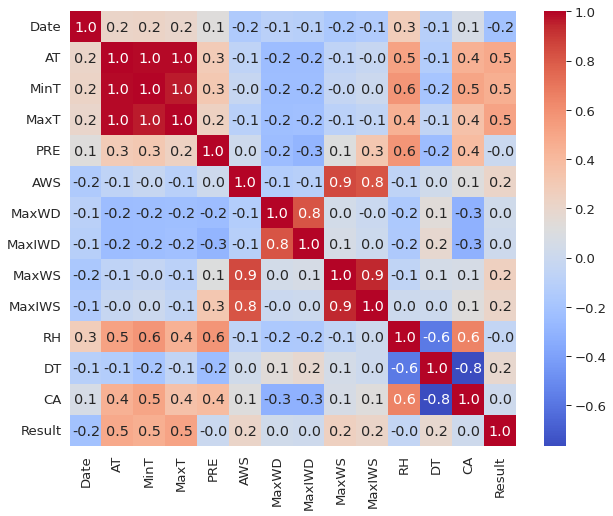

In [27]:
corr = df.corr()

sns.set_style('whitegrid')

sns.set_context('paper', font_scale=1.5)
plt.figure(figsize=(10, 8)) 
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.1f')

In [28]:
# Use a median imputer to replace missing values
imputer = SimpleImputer(strategy='median')

In [29]:
# Specify the target variable
y = df['Result']

In [30]:
# Specify the feature variables
X = df.drop(['Date', 'Result'], axis=1)

In [31]:
# Impute missing values
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

In [32]:
# Feature Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [33]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
# Define the hyperparameters grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [35]:
# Initialize Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

In [36]:
# Initialize GridSearchCV
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error')

In [37]:
# Fit GridSearchCV
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

In [38]:
# Print the best parameters
print("Best parameters: ", grid_search.best_params_)

Best parameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [39]:
# Initialize Random Forest Regressor with the best parameters
model = grid_search.best_estimator_

In [40]:
# Fit the model
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

In [41]:
# Make predictions
predictions = model.predict(X_test)

In [42]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE: %f" % (rmse))

RMSE: 0.008589


In [43]:
# Calculate MAE
mae = mean_absolute_error(y_test, predictions)
print("MAE: %f" % (mae))

MAE: 0.006473


In [44]:
# Calculate R2 Score
r2 = r2_score(y_test, predictions)
print("R2 Score: %f" % (r2))

R2 Score: 0.584126


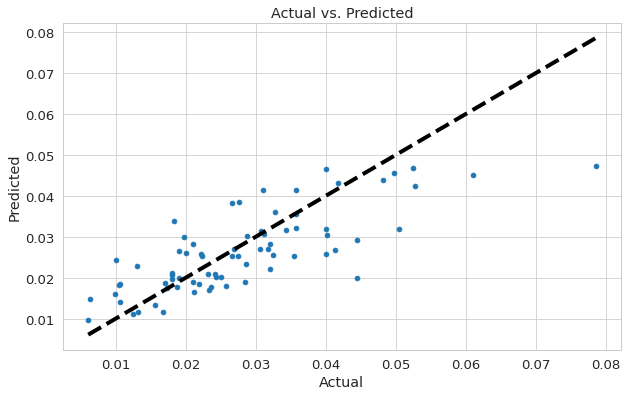

In [45]:
# Plot Actual vs. Predicted
plt.figure(figsize=(10,6))
plt.scatter(y_test, predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()

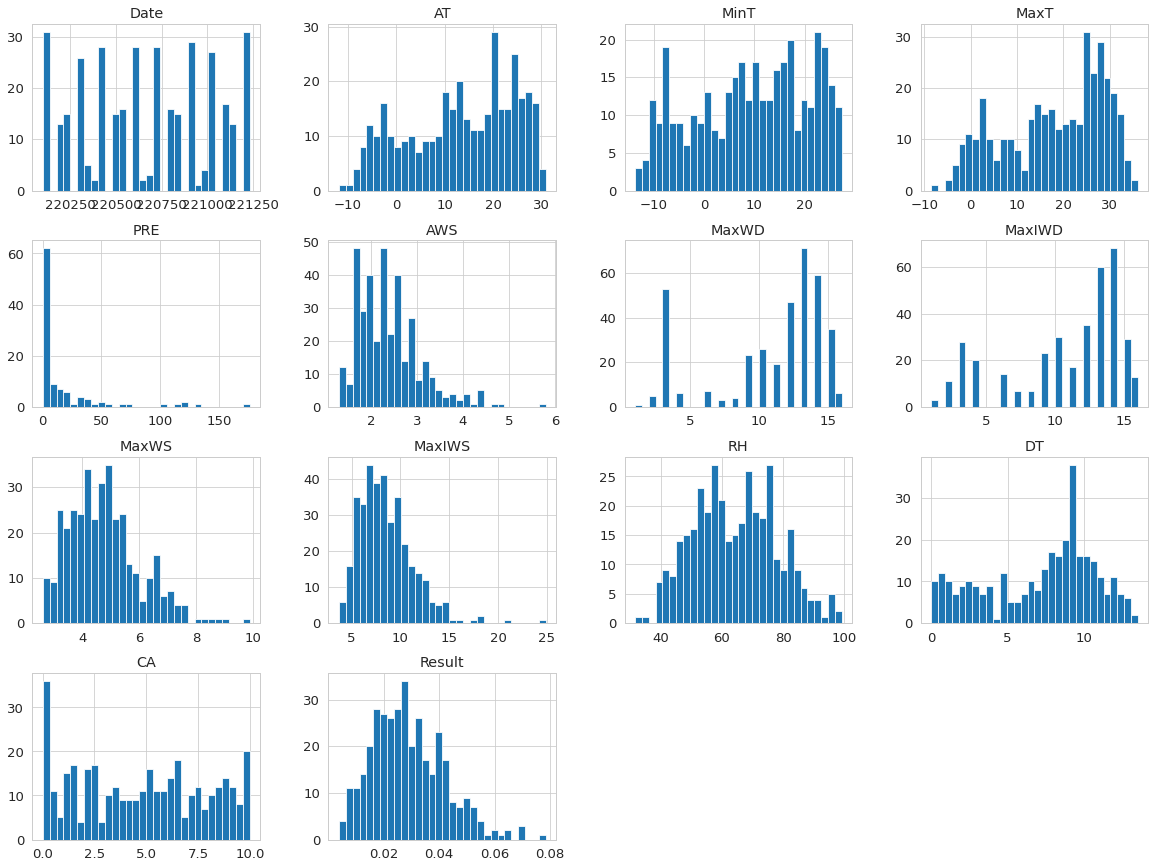

In [46]:
# Histograms for each variable in your dataset
df.hist(bins=30, figsize=(20,15))
plt.show()

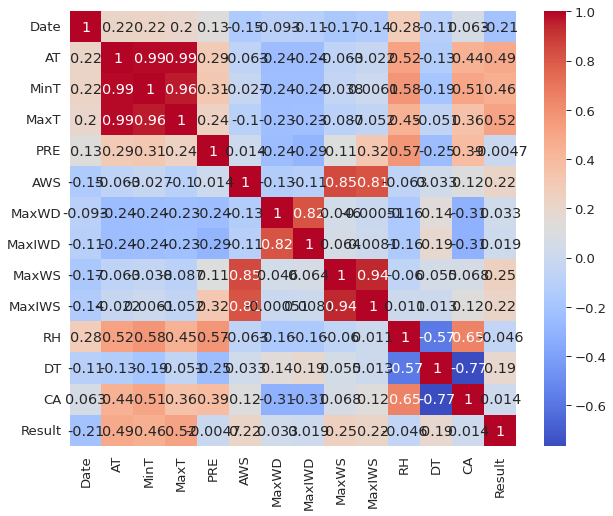

In [47]:
# Heatmap of Correlations
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

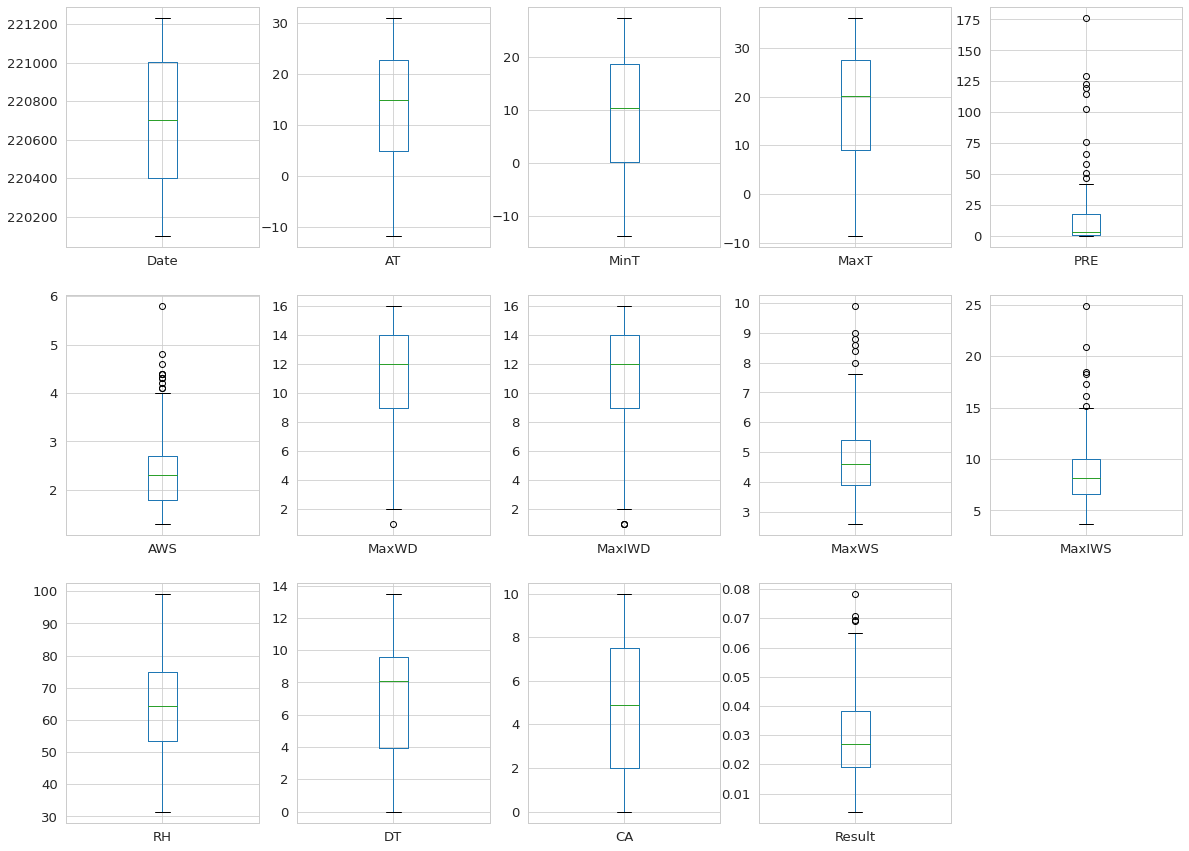

In [48]:
# Box plots for each variable
plt.figure(figsize=(20, 15))
for i, column in enumerate(df.columns, 1):
    plt.subplot(3, 5, i)
    df.boxplot(column)
plt.show()